<a href="https://colab.research.google.com/github/SaketMunda/food-vision-101/blob/master/food_vision101_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision App using Tensorflow

A Food Vision app which can tell from detecting the image that what kind of dish it is. The model will be trained by using all of the data from Food101 dataset.

Which has, 75,750 training images and 25,250 testing images of 101 classes (food item).

> **💡 Idea :** Using the food vision app model when user uploads an image, it can detect the image and then tell the amount of calories or micros on that dish based on the image detected. 

### Goal 

We'got the goal of beating [DeepFood](https://arxiv.org/abs/1606.05675), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

## Check GPUs

Since we're going to use mixed precision training which helps the model to train faster (was introduced in [TensorFLow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html)).

How it does ? In short it uses a combination of single precision (float32) and half precision (float16) datatypes to speed up model training (up 3x on modern GPUs).

But for mixed precision training to work, we need access to a GPU with a compatibility score of 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3f22da67-9e6b-5c81-b69b-33d840d58e66)


And Tesla T4 has the compatibility score more than 7.0. So thanks to Google colab for providing this GPU. 

Also check the version of Tensorflow


In [2]:
import tensorflow as tf

print(tf.__version__)

2.9.2


## Get Helper Functions

Import some of the helper functions that we created in `helper_functions.py` for unzipping data, walking through directories and few other stuffs.

In [3]:
# Get helper_functions.py script from Github
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves    

--2023-01-12 03:50:18--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-12 03:50:18 (51.1 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## Use TensorFlow Datasets To Download Data

For many of the popular datasets in the machine learning world (often referred to and used as benchmarks), we can access them through [TensorFLow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview)

In [4]:
# get tensorflow datasets
import tensorflow_datasets as tfds

In [6]:
# List available datasets
datasets_list = tfds.list_builders() # get all the available datasets
print("food101" in datasets_list)

True


It looks like the dataset we're after is available (note there are plenty more availabel but we're on Food101)

To get acchess to the Food101 dataset from TFDS, we can use the `tfds.load()` method.

In [7]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name='food101', # target dataset to get from TFDS
                                             split=['train', 'validation'], # What splits of data should we get ?
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g (image, label)
                                             with_info=True) # include dataset metadata ? if so, returns tuple(data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete88TOZE/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete88TOZE/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the `dataset_infor` variable (by using the `as_supervised=True` parameter) in the `tfds.load()` method.

In [8]:
# Features of food101 tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the classnames
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 dataset from TensorFlow Datasets

Let's find out a few details about our dataset,
- The shape of our input data (image tensors)
- The datatype of our input data
- What the labels of our input data look like (e.g one-hot encoded versus label-encoded)
- Do the labels match up with the class names ?

In [10]:
# Take one sample of the training dat
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

So it says, one sample is in the format of tuples (image_tensor, label)

In [15]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image dtype : {image.dtype}
  Target Class(tensor form) : {label}
  Class name (str form): {class_names[label.numpy()]}
  """
  )


  Image Shape : (512, 512, 3)
  Image dtype : <dtype: 'uint8'>
  Target Class(tensor form) : 41
  Class name (str form): french_onion_soup
  


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result everytime.

Checking these we can know that the shape of images have different shapes for example, (512, 512, 3) but all have the 3 color channels followed by height, width

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [16]:
# What does an image tensor from TFDS look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

I guess, the range of values of the above must be 0-255 as we all know that images have pixel values of (0,255)

In [17]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

There we go !

Now let's visualize by plotting one of the image with the label name to make things clear

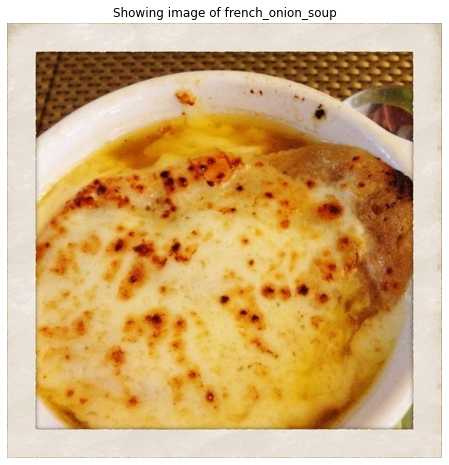

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title(f'Showing image of {class_names[label.numpy()]}')
plt.imshow(image)
plt.axis(False);

Healthy ! Looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions of our data

There are a couple of of preprocessing steps we have to take before it's ready to model,

More specifically, our data is currently:
- In `uint8` datatype
- Comprised of all different size tensors(different sized image)
- Not scaled (the pixel values are between 0 & 255)

Whereas, models like the data to be:
- In `float32` datatype
- Have all of the same size tensors (batches require all tensors have the same shape, e.g `(224, 224, 3)`)
- Scaled (values between 0 & 1), also called normalized

In [20]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` to `float32` and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label

Let's try our function out on a target image

In [21]:
preprocess_img = preprocess_img(image, label)

In [23]:
preprocess_img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[194.12755, 174.12755, 149.12755],
        [204.66325, 184.66325, 159.66325],
        [198.20918, 180.42348, 158.85204],
        ...,
        [200.12253, 186.55106, 160.97958],
        [204.22949, 190.22949, 164.22949],
        [195.14168, 179.14168, 154.14168]],

       [[197.10204, 177.10204, 150.10204],
        [202.5102 , 185.5102 , 159.5102 ],
        [209.96428, 193.83673, 169.47958],
        ...,
        [201.301  , 187.72952, 162.15805],
        [207.8622 , 193.8622 , 167.8622 ],
        [197.218  , 183.218  , 157.218  ]],

       [[192.0153 , 175.44388, 147.2296 ],
        [202.11224, 185.32652, 159.32652],
        [209.37755, 193.59183, 169.0204 ],
        ...,
        [205.13773, 191.28563, 167.99481],
        [208.99998, 194.99998, 168.99998],
        [201.62102, 187.62102, 161.62102]],

       ...,

       [[227.88795, 220.10222, 201.31648],
        [236.76028, 228.18881, 212.8623 ],
        [231.43372, 221.862

It looks like it casted it into float32 and also changed the shape to (224, 224, 3)

In [ ]:
## Batch and prepare datasets
